# Unsupervised Anomaly Detection on Hyperthyroid Data
*   This notebook has created to detect anomalies on hyperthyroid data which has both continuous and categorical features.
*   Nearest Neighbours, DBSCAN and Isolation Forest algorithms has been used for anomaly detection.









# Library Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# CSV file is fetched and a pandas data frame created
df = pd.read_csv('/content/drive/MyDrive/data/hyperthyroid.csv', sep= ";")

In [ ]:
# Unnecessary columns at the dataframe are discarded
df = df.drop(columns = ['Row','Unnamed: 22', 'Unnamed: 23'],axis =1)
df.head()

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_11=0,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20
0,"0,750000",1,0,1,1,1,1,1,0,1,...,1,1,1,1,1,"0,001132","0,080780","0,197324","0,300926","0,225000"
1,"0,239583",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,"0,000472","0,164345","0,235786","0,537037","0,165625"
2,"0,479167",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,"0,003585","0,130919","0,167224","0,527778","0,118750"
3,"0,656250",0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,"0,001698","0,091922","0,125418","0,337963","0,129688"
4,"0,229167",1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,"0,000472","0,142061","0,229097","0,337963","0,235938"


In [ ]:
# Checked if data has NaN values
num_missing = df.isna()
print(num_missing.sum())

Dim_0       0
Dim_1=0     0
Dim_2=0     0
Dim_3=0     0
Dim_4=0     0
Dim_5=0     0
Dim_6=0     0
Dim_7=0     0
Dim_8=0     0
Dim_9=0     0
Dim_10=0    0
Dim_11=0    0
Dim_12=0    0
Dim_13=0    0
Dim_14=0    0
Dim_15=0    0
Dim_16      0
Dim_17      0
Dim_18      0
Dim_19      0
Dim_20      0
dtype: int64


There is no missing values

In [ ]:
# Data types checked
df.dtypes

Dim_0       object
Dim_1=0      int64
Dim_2=0      int64
Dim_3=0      int64
Dim_4=0      int64
Dim_5=0      int64
Dim_6=0      int64
Dim_7=0      int64
Dim_8=0      int64
Dim_9=0      int64
Dim_10=0     int64
Dim_11=0     int64
Dim_12=0     int64
Dim_13=0     int64
Dim_14=0     int64
Dim_15=0     int64
Dim_16      object
Dim_17      object
Dim_18      object
Dim_19      object
Dim_20      object
dtype: object



*   The type of the categorical features are int64
*   The type of the continuous features are object



# Data Standardization and Converting

In [ ]:
from sklearn.preprocessing import StandardScaler

# Object types converted to float for computational stability for continuous features
# Commas replaced with dots
continuous_features = ['Dim_0', 'Dim_16', 'Dim_17', 'Dim_18', 'Dim_19', 'Dim_20']
for col in continuous_features:
    df[col] = df[col].str.replace(',', '.').astype(float)

# Standard scaler applied to continuos features
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

# Data type converted int64 to int8 for efficiency in categorical features
categorical_features = [col for col in df.columns if col.startswith('Dim_') and col.endswith('=0')]
df[categorical_features] = df[categorical_features].astype('int8')

# Resulting Dataframe display
print(df.dtypes)

Dim_0       float64
Dim_1=0        int8
Dim_2=0        int8
Dim_3=0        int8
Dim_4=0        int8
Dim_5=0        int8
Dim_6=0        int8
Dim_7=0        int8
Dim_8=0        int8
Dim_9=0        int8
Dim_10=0       int8
Dim_11=0       int8
Dim_12=0       int8
Dim_13=0       int8
Dim_14=0       int8
Dim_15=0       int8
Dim_16      float64
Dim_17      float64
Dim_18      float64
Dim_19      float64
Dim_20      float64
dtype: object


In [ ]:
# The shape of the data determined
[N, M] = df.shape

# Gower Distance Proximity Matrix

Gower distance proximity matrix is selected since we have different data types, we cannot use one distance metric for the whole data.

In [ ]:
# Gower library installed with pip
!pip install gower

In [ ]:
# Array for indexing categorical columns created
categorical_col = [False for _ in range(M)]
for i, col in enumerate(df.columns):
    if df[col].dtype == f'int8' : # loop over the categorical feautures
        categorical_col[i] = True

categorical_col_indexes = list(np.where(categorical_col)[0])
print(categorical_col)
print(categorical_col_indexes)

[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
# Gower distance matrix created
import gower
gower_dist_matrix = gower.gower_matrix(df, cat_features = categorical_col) # giving the indexes of the categorical columns

In [ ]:
# Values of the gower distance matrix checked
gower_dist_matrix

array([[0.        , 0.13945667, 0.12793462, ..., 0.16172586, 0.17053723,
        0.15324958],
       [0.13945667, 0.        , 0.01908662, ..., 0.08438928, 0.07037228,
        0.09033491],
       [0.12793462, 0.01908662, 0.        , ..., 0.06997181, 0.06661309,
        0.07327476],
       ...,
       [0.16172586, 0.08438928, 0.06997181, ..., 0.        , 0.11066329,
        0.01999171],
       [0.17053723, 0.07037228, 0.06661309, ..., 0.11066329, 0.        ,
        0.11604414],
       [0.15324958, 0.09033491, 0.07327476, ..., 0.01999171, 0.11604414,
        0.        ]], dtype=float32)

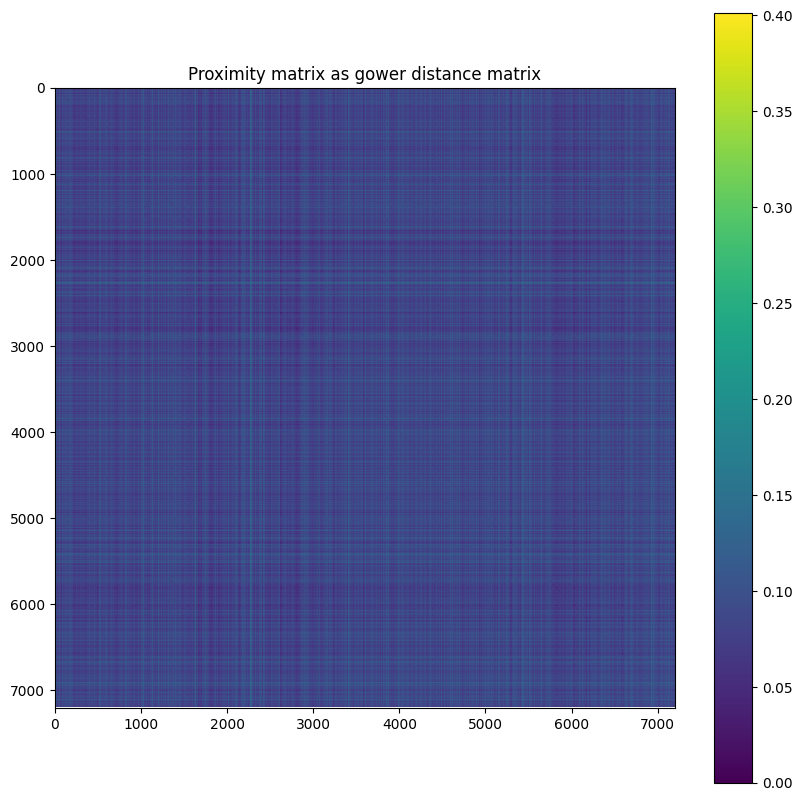

In [ ]:
# Plotting proximity matrix
from scipy.spatial.distance import squareform as sf

PM = gower_dist_matrix

plt.figure(figsize=(10,10))
plt.imshow(PM)
plt.title('Proximity matrix as gower distance matrix')
plt.colorbar()
plt.show()

Because there are so many data points we cannot observe any outliers by proximity matrix.

# Plotting the Histograms of the Features

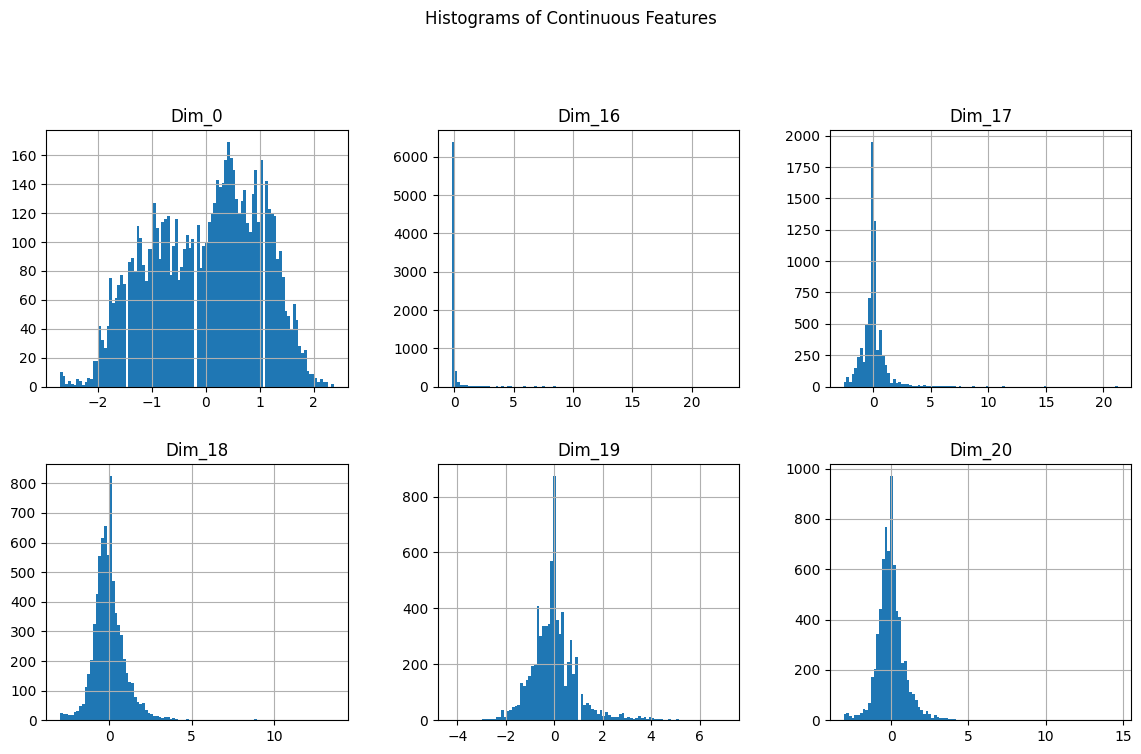

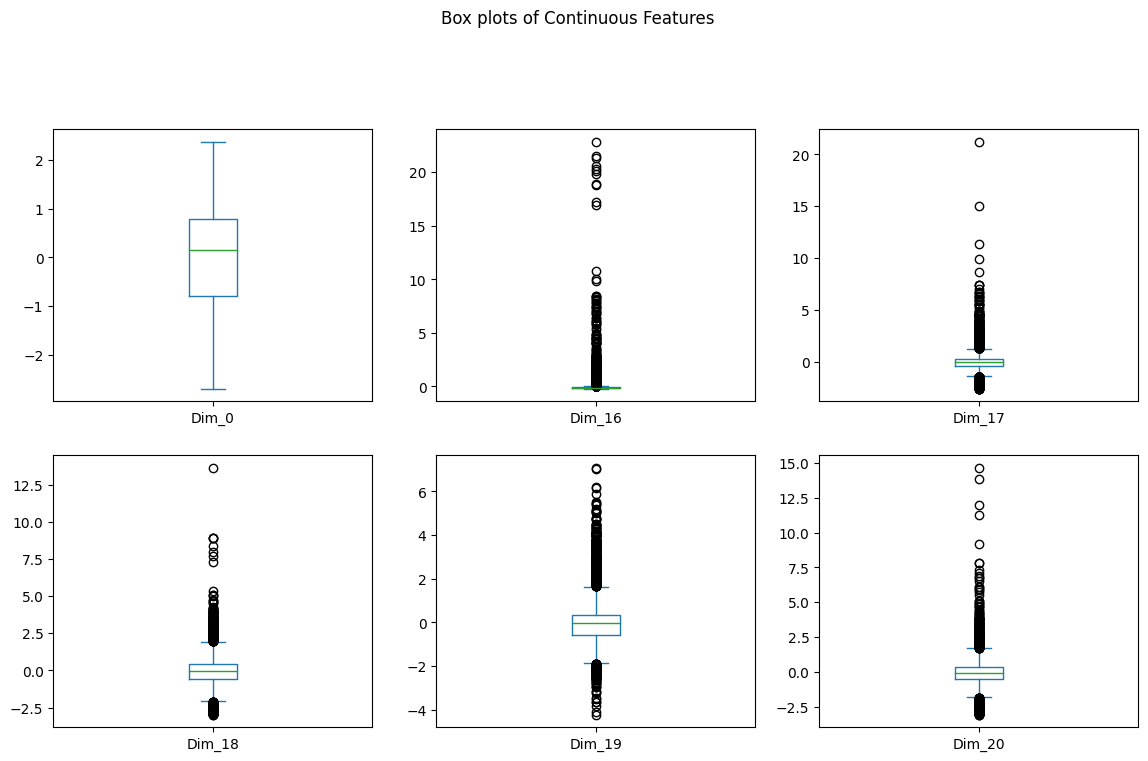

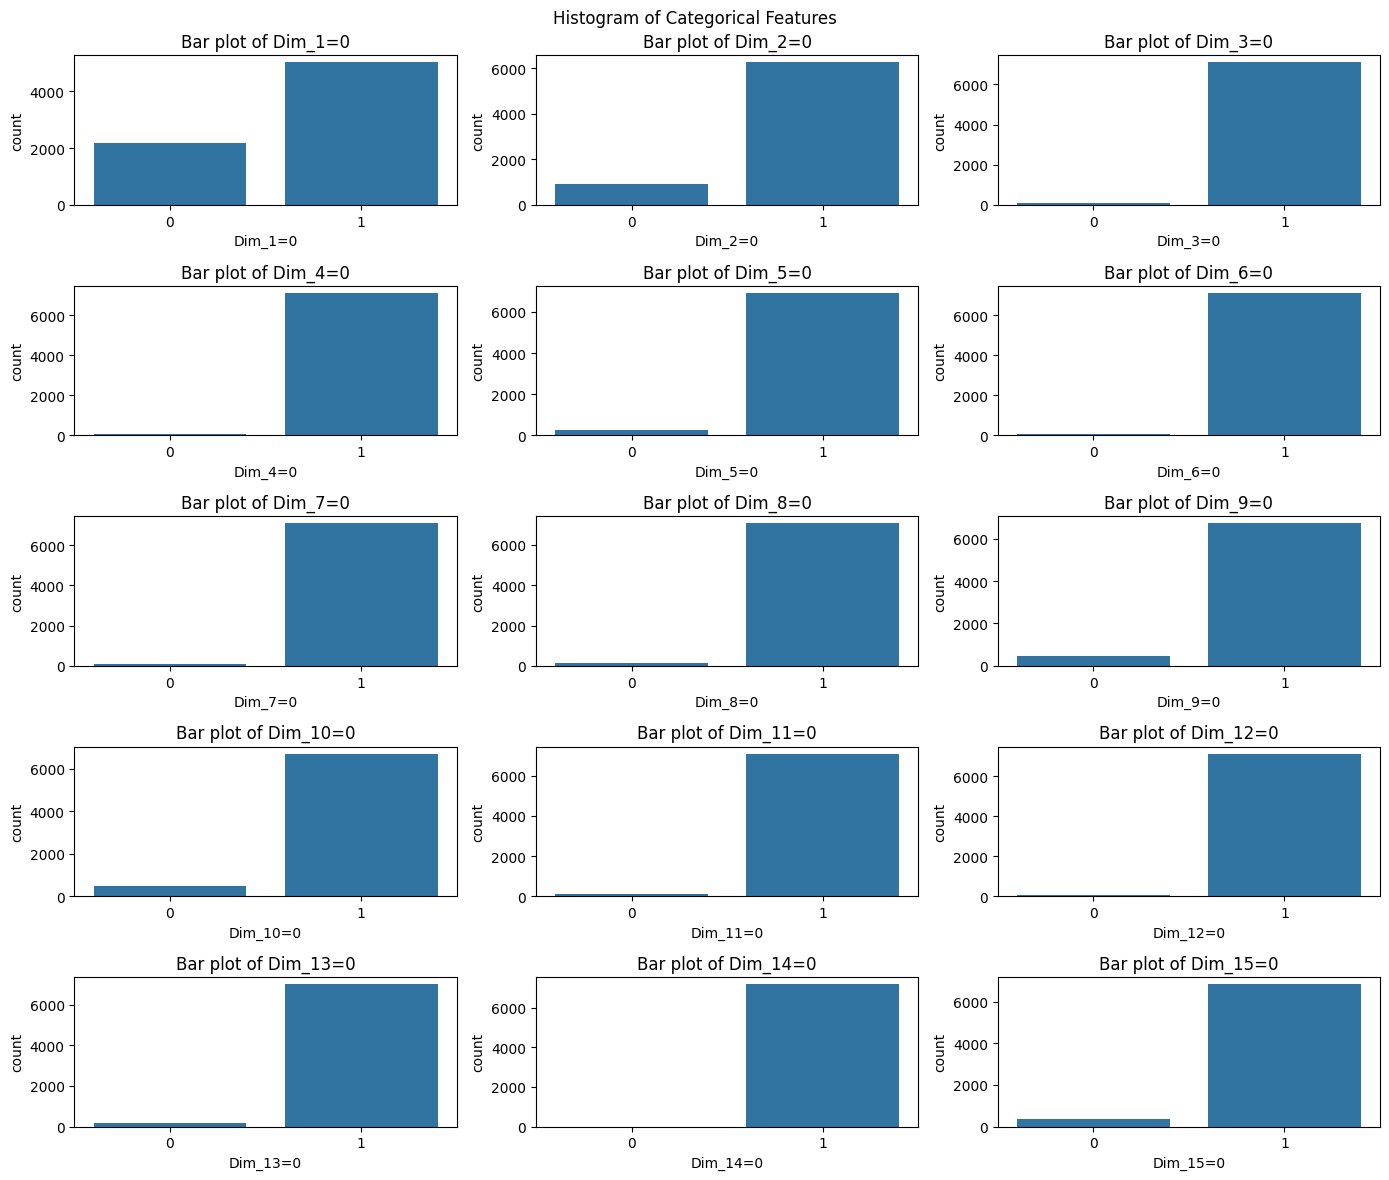

In [ ]:

# The distributions of continuous features visualized
df[continuous_features].hist(bins=100, figsize=(14, 12), layout=(3, 3))
plt.suptitle('Histograms of Continuous Features')
plt.show()

# The distributions of categorical features visualized
df[continuous_features].plot(kind='box', subplots=True, layout=(3, 3), figsize=(14, 12))
plt.suptitle('Box plots of Continuous Features')
plt.show()


# Plotting the categorical features in a 5x3 matrix
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Bar plot of {col}')


plt.suptitle('Histogram of Categorical Features')
plt.tight_layout()
plt.show()

# Correlation Matrix


Correlation matrix is to find correlated features.

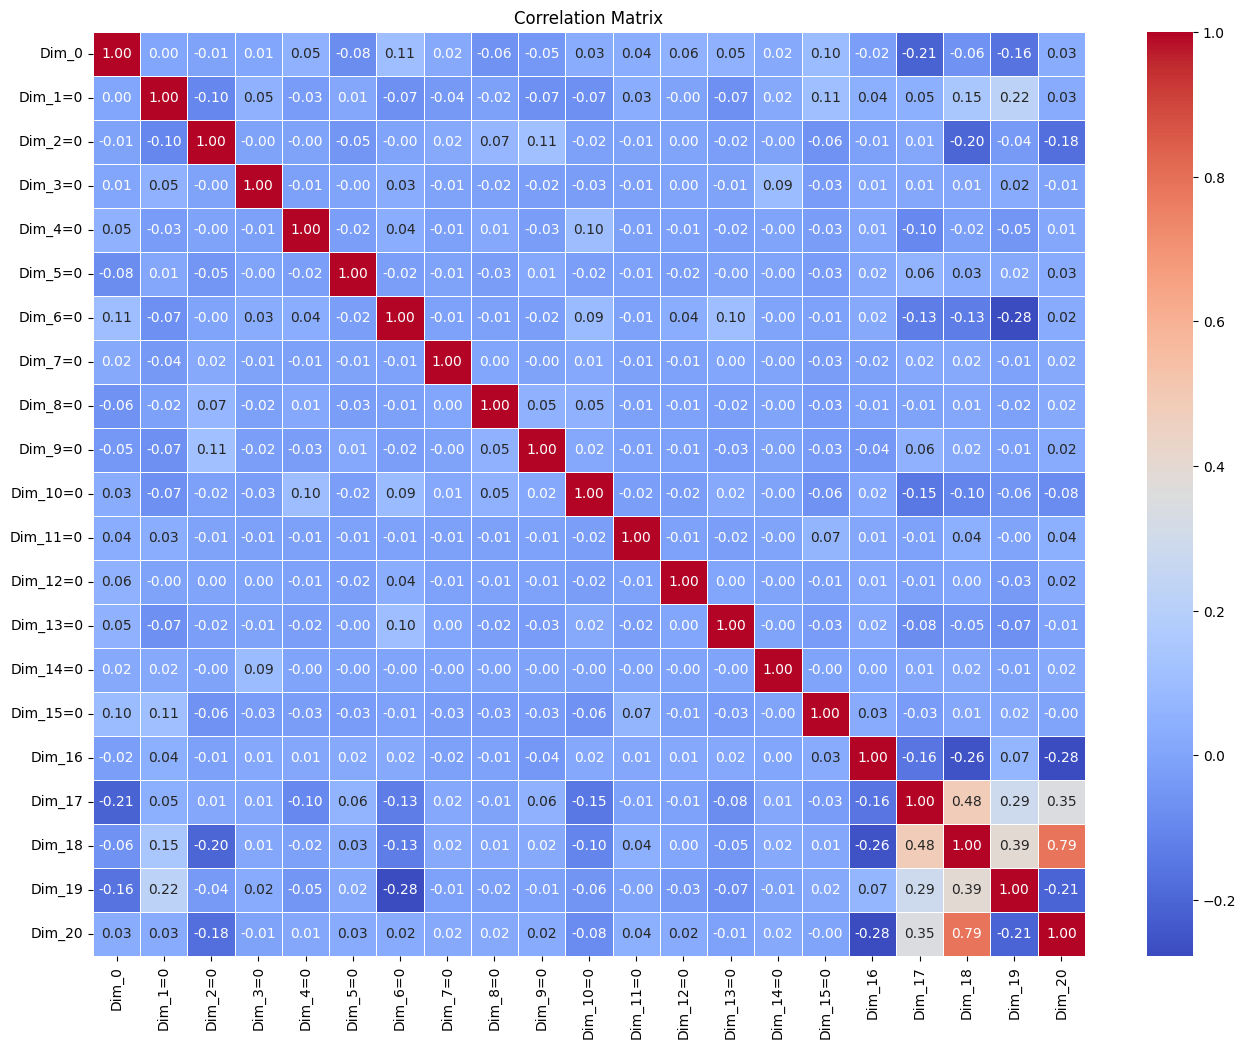

Highly correlated features (threshold > 0.8):


In [ ]:
# Correlation matrix created
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Identify highly correlated features
# (absolute value of correlation coefficient > 0.8)
threshold = 0.8
highly_correlated_features = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print("Highly correlated features (threshold > 0.8):")
for pair in highly_correlated_features:
    print(pair)

There are only 2 features highly correlated but they are on the threshold value (0.8), we decide not to remove any of them.

# tSNE plot

In [ ]:
from sklearn.manifold import TSNE

np.random.seed(100)
tsne = TSNE(n_components=2, perplexity=20, n_iter=300)
# To show the plot in the figure n_components = 2.
# Perplexity=20 as a moderate choice for tSNE to capture global structure mostly and also details.
# Algorithm does 300 iteration until stops

tsne_results = tsne.fit_transform(gower_dist_matrix)


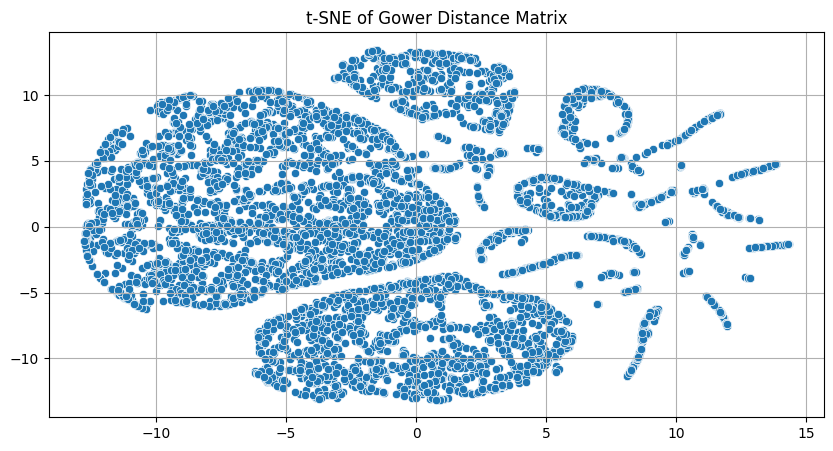

In [ ]:
plt.figure(figsize=(10,5))
plt.title('t-SNE of Gower Distance Matrix')

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1])

plt.grid()

plt.show()

# It is shown that there are different density areas in the data

# Apply Knee Point

In [ ]:
!pip install kneed

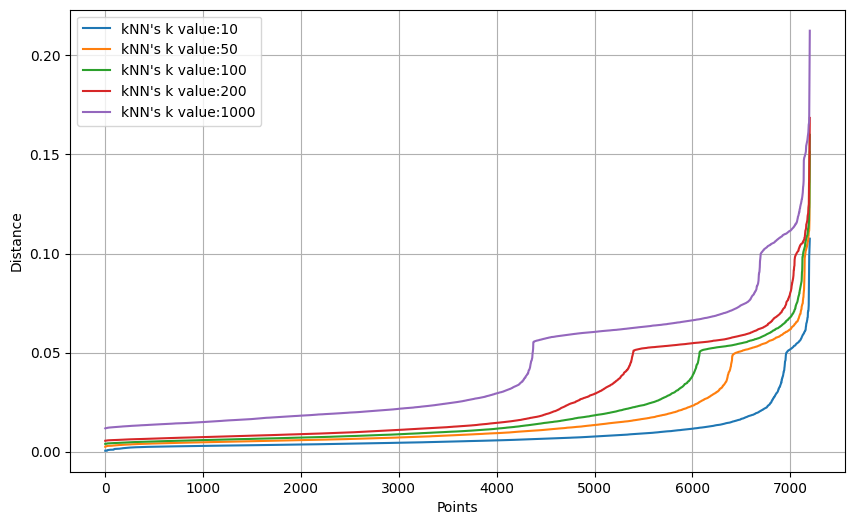

In [ ]:
# KNEE METHOD optimal eps value applied
from sklearn.neighbors import NearestNeighbors as knn
from sklearn.cluster import DBSCAN

MINSAMPLES = [10,50,100,200,1000] # Different number of neighborhoods to try

plt.figure(figsize=(10, 6))
for neighborhood_order in MINSAMPLES:
    neighborhood_set = knn(n_neighbors=neighborhood_order,metric = "precomputed").fit(gower_dist_matrix)
    # Algorithm isn't selected, default = auto most, which is most proper one for our distance matrix

   # Found K-neighbors of a point and return distances and indices
    distances, indices = neighborhood_set.kneighbors(gower_dist_matrix)

    # The distances from each point sorted to their Nth nearest neighbour
    distances = np.sort(distances[:,neighborhood_order-1], axis=0)


    plt.plot(distances, label = f"kNN's k value:{neighborhood_order}")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.legend()
plt.grid()
plt.show()

Distance-Points is plotted according to different number of neighbors.

In [ ]:
MIN_SAMPLES = 100 # min sample selected as 100 according to Distance - Point graph
neighborhood_order = MIN_SAMPLES
neighborhood_set   = knn(n_neighbors=neighborhood_order,metric = "precomputed").fit(gower_dist_matrix)

distances, indices = neighborhood_set.kneighbors(gower_dist_matrix) # To find the K-neighbors of a point and return distances
dist_mean = np.mean(distances, axis = 1)
distances          = np.sort(distances[:,neighborhood_order-1], axis=0)


In [ ]:
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

# Knee point selected using KneeLocator library
# The convex increasing point selected
knee_x = knee.knee
knee_y = knee.knee_y
print('The estimated best eps value is = %.2f' % knee_y)

The estimated best eps value is = 0.02


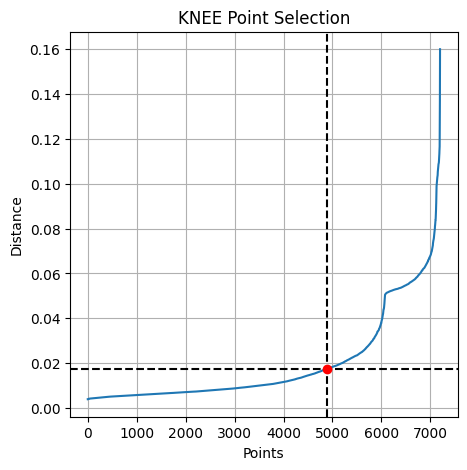

In [ ]:
# Show knee point coordinates for selected "n_neighbors" value
# Plotting the average distance to 85 nearest neighbors
fig = plt.figure(figsize = (5,5))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid()

plt.axvline(x=knee_x, color='k', linestyle='--')
plt.axhline(y=knee_y, color='k', linestyle='--')
plt.plot((knee_x), (knee_y), 'o', color='r')
plt.title("KNEE Point Selection")
plt.show()

# Investigation on outliers using Nearest Neighbors Method

In [ ]:
# According to knee_y point outliers selected
# The points above the knee_y point are counted as outliers
outliers = np.where(dist_mean >= knee_y)[0]
outlier_data = df.iloc[outliers]

print(f"Number of outliers detected: {len(outlier_data)}")

Number of outliers detected: 1609


In [ ]:
print(outliers) # Printed the outlier indices

[   0   19   27 ... 7191 7196 7199]


# Investigation on outliers using DBSCAN clustering

In [ ]:
# Set the optimal eps for DBSCAN.
EPS_KNEE = knee_y
knee_y

0.017424857

In [ ]:
# Apply DBSCAN method
dbscan = DBSCAN(eps = EPS_KNEE, min_samples=MIN_SAMPLES, metric='precomputed').fit(gower_dist_matrix)

# Retrieve the labels
dbscan_labels = dbscan.labels_

# See unique labels
unique_labels = np.unique(dbscan_labels)
print(unique_labels)

print("Estimated number of clusters: %d" % len(unique_labels))
 # Subtract 1 for noise points.

[-1  0  1  2  3  4  5  6  7]
Estimated number of clusters: 9


# Validate the DBSCAN clustering solution

In [ ]:
# The number of core/border/noise points.
corep = np.size(dbscan.core_sample_indices_)
noisep = list(dbscan_labels).count(-1)
boardp = N - corep - noisep

print("There are %d core points and %d border points." % (corep,boardp))
print("The number of noise points found by DBSCAN: %d." % noisep)

There are 4886 core points and 815 border points.
The number of noise points found by DBSCAN: 1499.


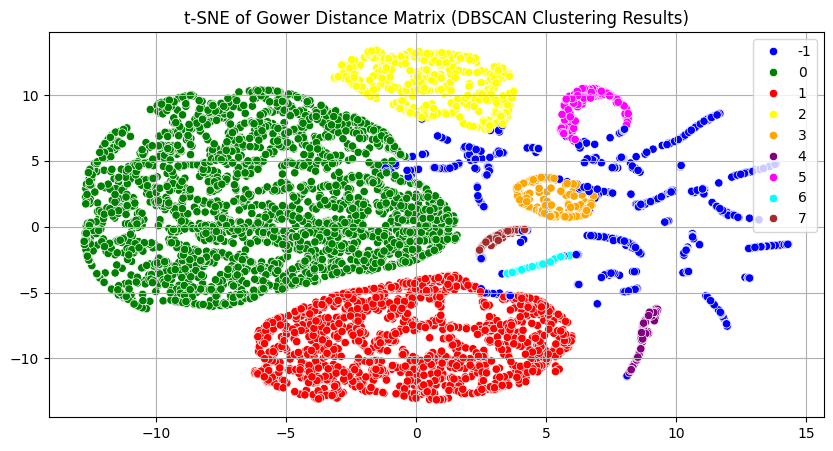

In [ ]:
# The clustering solution visualized
PAL = ['blue', 'green', 'red', 'yellow', 'orange', 'purple', 'magenta', 'cyan', 'brown']

# tSNE plot with DBSCAN clustering results
np.random.seed(100) # Random seed for reproducability
tsne = TSNE(n_components=2, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(gower_dist_matrix)

plt.figure(figsize=(10,5))
plt.title('t-SNE of Gower Distance Matrix (DBSCAN Clustering Results)')

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=dbscan_labels, palette=PAL)

plt.grid()

plt.show()


In [ ]:
def add_cluster_labels(df, labels, column_name='Cluster_Labels'):
    """
    Adds a new column with cluster labels to the dataframe.

    Parameters:
    df (pd.DataFrame): The original dataframe.
    labels (list or array): The cluster labels to be added.
    column_name (str): The name of the new column to be added.

    Returns:
    pd.DataFrame: The dataframe with the new column added.
    """
    if len(df) != len(labels):
        raise ValueError("The length of the labels list must match the number of rows in the dataframe.")

    df[column_name] = labels
    return df


In [ ]:
add_cluster_labels(df, dbscan_labels, column_name='Labels')

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,Labels
0,1.106869,1,0,1,1,1,1,1,0,1,...,1,1,1,1,-0.185460,-0.660168,0.293878,-0.829940,0.908303,-1
1,-1.482215,1,1,1,1,1,1,1,1,1,...,1,1,1,1,-0.200684,1.329573,0.933377,1.842567,-0.144473,0
2,-0.266928,1,1,1,1,1,1,1,1,1,...,1,1,1,1,-0.128880,0.533676,-0.206589,1.737765,-0.975611,0
3,0.631323,0,1,1,1,1,1,1,1,1,...,1,1,1,1,-0.172405,-0.394869,-0.901688,-0.410723,-0.781670,1
4,-1.535050,1,1,1,1,1,1,1,1,1,...,1,1,1,1,-0.200684,0.798975,0.822161,-0.410723,1.102244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.367133,1,1,1,1,1,1,1,1,1,...,1,1,1,0,-0.102769,0.109203,-0.846071,0.060899,-0.920202,6
7196,-0.055578,1,1,1,1,1,1,1,1,1,...,1,1,1,1,4.401598,-1.854013,-2.903570,-0.463130,-2.984192,0
7197,-0.055578,1,1,1,1,1,1,1,1,1,...,1,1,1,0,-0.178494,0.016341,-0.540238,-1.615978,0.575847,6
7198,-0.900989,0,1,1,1,1,1,1,1,1,...,1,1,1,1,-0.089714,0.016341,-0.540238,-0.463130,-0.338396,1


In [ ]:
import random
def plot_random_attributes(df, anomaly_column, categorical_features, continuous_features, n_plots=3):

    for _ in range(n_plots):
      categorical_features = random.sample(categorical_features, 2)
      continuous_features = random.sample(continuous_features, 2)

      plt.figure(figsize=(14, 6))

      # Plot categorical attributes
      plt.subplot(1, 2, 1)
      plt.scatter(df[categorical_features[0]], df[categorical_features[1]], c=df[anomaly_column].apply(lambda x: 1 if x == 'anomaly' else 0), cmap='coolwarm', alpha=0.7)
      plt.title('Random Categorical Attributes')
      plt.xlabel(categorical_features[0])
      plt.ylabel(categorical_features[1])

      # Plot continuous attributes
      plt.subplot(1, 2, 2)
      plt.scatter(df[continuous_features[0]], df[continuous_features[1]], c=df[anomaly_column].apply(lambda x: 1 if x == 'anomaly' else 0), cmap='coolwarm', alpha=0.7)
      plt.title('Random Continuous Attributes')
      plt.xlabel(continuous_features[0])
      plt.ylabel(continuous_features[1])

      plt.show()

In [ ]:
from scipy.spatial import distance

def intra_inter_clusters(df, label_column):
    """
    Plots the data instances and the cluster centers according to two attributes.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data and cluster labels.
    attribute1 (str): The first attribute to be used for the x-axis.
    attribute2 (str): The second attribute to be used for the y-axis.
    label_column (str): The name of the column containing the cluster labels.
    """
    # Exclude noise points
    clustered_df = df[df[label_column] != -1]
    noise_df = df[df[label_column] == -1]

    # Group by cluster labels and calculate the mean for each cluster
    cluster_centers = clustered_df.groupby(label_column).mean()

    for label, center in cluster_centers.iterrows():
        coordinates = ' '.join(f'{x:.2f}' for x in center.values)
        print(f'The centroid of cluster {label} has coordinates: {coordinates}')
    print("\n")

    intra_distances = {}

    for label in cluster_centers.index:
        cluster_data = clustered_df[clustered_df[label_column] == label].drop(columns=[label_column])
        center = cluster_centers.loc[label].values
        distances = distance.cdist(cluster_data, [center], metric='euclidean')
        intra_distances[label] = np.mean(distances).round(3)


    inter_distances = pd.DataFrame(distance.cdist(cluster_centers, cluster_centers, metric='euclidean'),
                                   index=cluster_centers.index, columns=cluster_centers.index).round(3)

    print(f"intra distances are:\n{intra_distances}\n")

    print(f"inter distances are:\n{inter_distances}")

    return cluster_centers

In [ ]:
# Find clusters centers.
centers = intra_inter_clusters(df, 'Labels')

The centroid of cluster 0 has coordinates: 0.04 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 -0.05 -0.05 -0.03 0.07 -0.08
The centroid of cluster 1 has coordinates: 0.04 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 -0.09 -0.13 -0.28 -0.35 -0.08
The centroid of cluster 2 has coordinates: 0.05 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 -0.09 -0.02 0.67 0.15 0.57
The centroid of cluster 3 has coordinates: 0.06 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 -0.10 0.28 0.12 0.15 0.02
The centroid of cluster 4 has coordinates: -0.56 0.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 -0.14 0.18 -0.07 -0.20 0.02
The centroid of cluster 5 has coordinates: 0.37 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.00 1.00 1.00 1.00 1.00 1.00 1.00 0.06 -0.29 -0.23 -0.00 -0.23
The centroid of cluster 6 has coordinates: -0.65 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.0

Intra-inter cluster distances interpretation:

The intra-cluster distances indicate that most clusters are reasonably compact, with clusters 6 and 7 being the most tightly clustered. The inter-cluster distances reveal that some clusters, such as clusters 0, 1, 3, and 5, are not well-separated, suggesting potential overlap and less distinct boundaries.

In [ ]:
df = df.drop(['Labels'], axis = 1) # DBSCAN labels column are dropped due they are unnecessary for Isolation Forest Algorithm

In [ ]:
# Silhouette score
from sklearn.metrics import silhouette_score

Ss = silhouette_score(gower_dist_matrix, dbscan_labels, metric= "precomputed")
print("With DBSCAN clustering, we found an optimal number of clusters equal to %d with a silhouette score of %.3f." % (len(unique_labels), Ss))

With DBSCAN clustering, we found an optimal number of clusters equal to 9 with a silhouette score of 0.421.


Since the silhouette score is greater than 0 but not close to 1, it indicates moderate clustering performance.

In [ ]:
# Correlation coefficient between the ideal similarity matrix (DBSCAN) and the proximity matrix (gower distance matrix)
# Ideal similarity matrix for DBSCAN clustering
SM_db = np.eye(N)
for i in range(0, dbscan_labels.size):
   for j in range(0, dbscan_labels.size):
       if dbscan_labels[i] == dbscan_labels[j]:
        SM_db[i,j] = 1
        SM_db[j,i] = 1

# The correlation between the ideal similarity matrix and the proximity matrix
PM_values = PM[np.triu_indices_from(PM, k=1)]
SM_db_values = SM_db[np.triu_indices_from(SM_db, k=1)]
ro_db = np.abs( np.corrcoef(PM_values, SM_db_values)[0,1].round(2))

print('For DBSCAN clustering solutions (with %d clusters),' %len(unique_labels), 'we obtain a cross-correlation of %.2f.' % ro_db )

For DBSCAN clustering solutions (with 9 clusters), we obtain a cross-correlation of 0.47.


In [ ]:
# Remove outliers
noise_ind = np.array( np.where(dbscan_labels==-1) )

PM_red    = np.delete(PM, noise_ind, axis=0)
PM_red    = np.delete(PM_red, noise_ind, axis=1)

SM_db_red = np.delete(SM_db, noise_ind, axis=0)
SM_db_red = np.delete(SM_db_red, noise_ind, axis=1)

In [ ]:
# Compute the correlation between the ideal similarity matrix and the proximity matrix
PM_red_values = PM_red[np.triu_indices_from(PM_red, k=1)]
SM_db_red_values = SM_db_red[np.triu_indices_from(SM_db_red, k=1)]
ro_db_red = np.abs( np.corrcoef(PM_red_values, SM_db_red_values)[0,1].round(2))
print('For this DBSCAN clustering solution (with %d clusters), \nafter removing %d outliers (i.e., %.1f%% of the entire dataset), \nwe obtain a' % (len(unique_labels), noisep, noisep/N*100), 'cross-correlation of %.2f.' % ro_db_red )

For this DBSCAN clustering solution (with 9 clusters), 
after removing 1499 outliers (i.e., 20.8% of the entire dataset), 
we obtain a cross-correlation of 0.80.


As it can be seen, when noise points are removed there is a significant increase in cross-correlation. This supports that noise points are found by DBSCAN tend to be outliers.

# Investigation on outliers using Isolation Forest

In [ ]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest


def convert_labels(label):
    return 1 if label == 'normal' else -1


# Preprocessing for continuous and categorical features is defined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', continuous_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# A pipeline with preprocessing and Isolation Forest created
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('isolation_forest', IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination='auto',
        max_features=1.0,
        random_state=42
    ))
])

# Fit the model
pipeline.fit(df)

# Get anomaly scores
anomaly_scores = pipeline.named_steps['isolation_forest'].decision_function(
    pipeline.named_steps['preprocessor'].transform(df)
)

# Add the anomaly score to the dataframe
df['IF_anomaly_scores'] = anomaly_scores

# Threshold is determined to detect anomalisd based on the anomaly scores
threshold = pd.Series(anomaly_scores).quantile(0.05)

# Instances are labeled as anomalies or normal
df['IF_anomaly'] = df['IF_anomaly_scores'].apply(lambda x: 'anomaly' if x < threshold else 'normal')

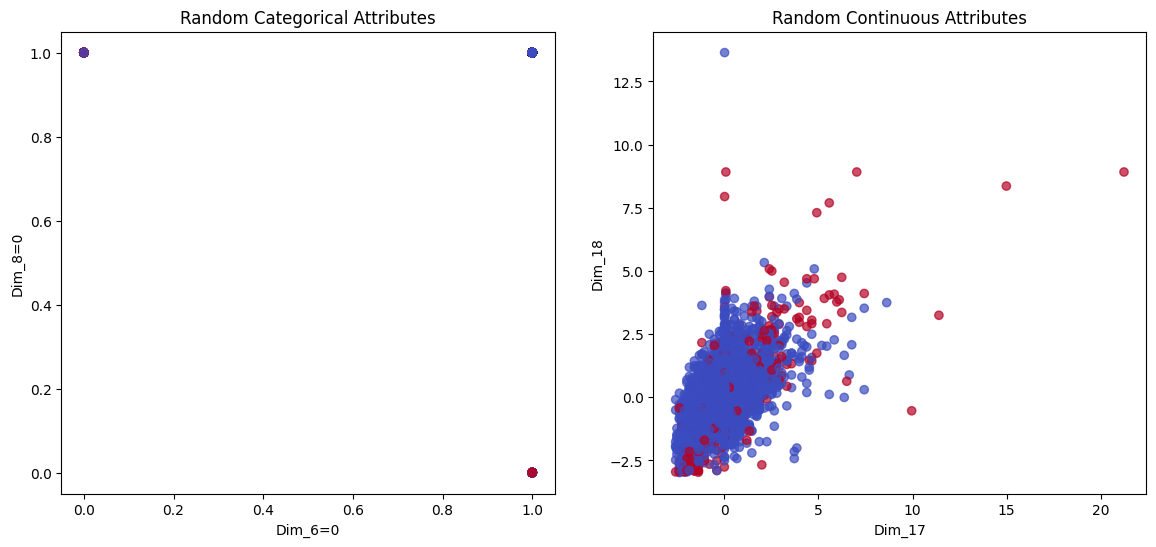

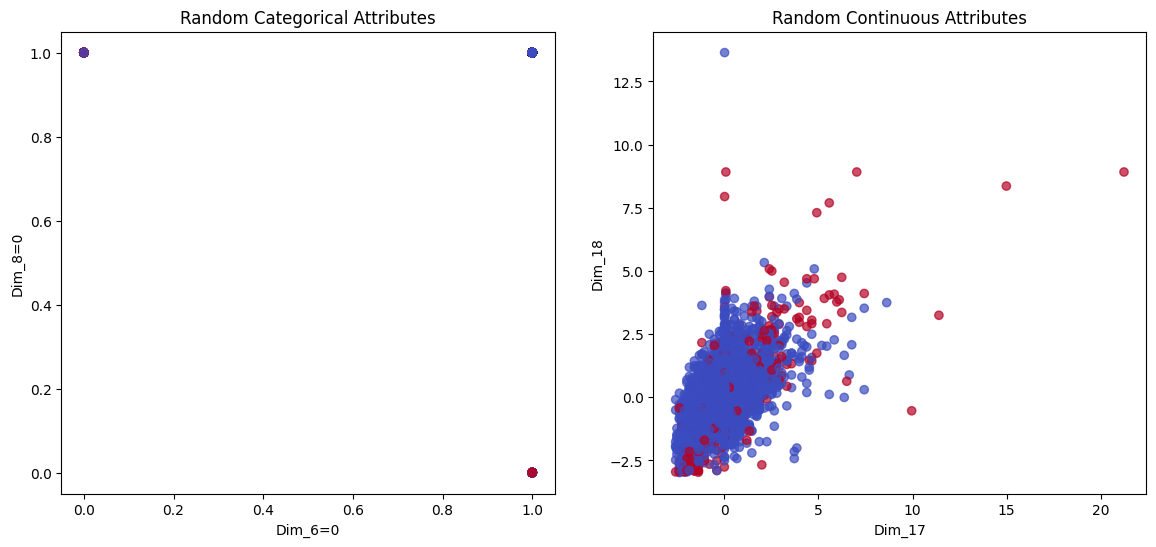

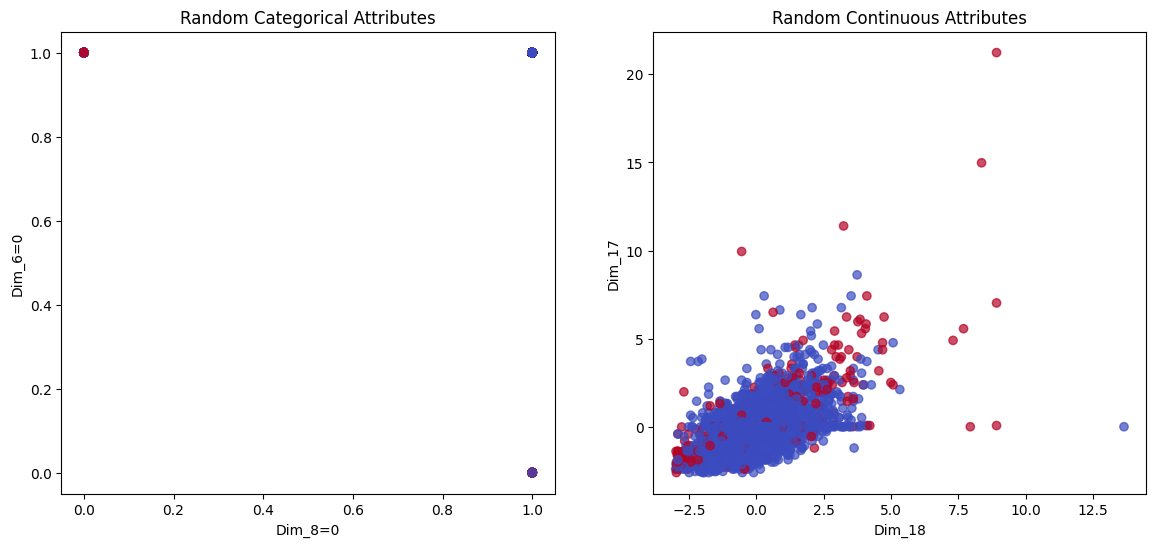

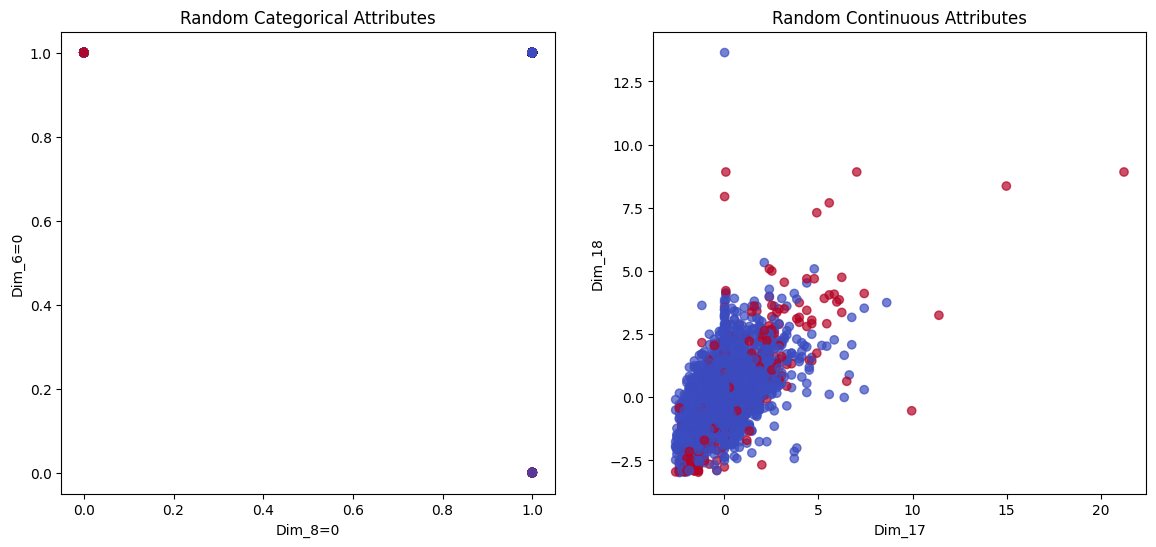

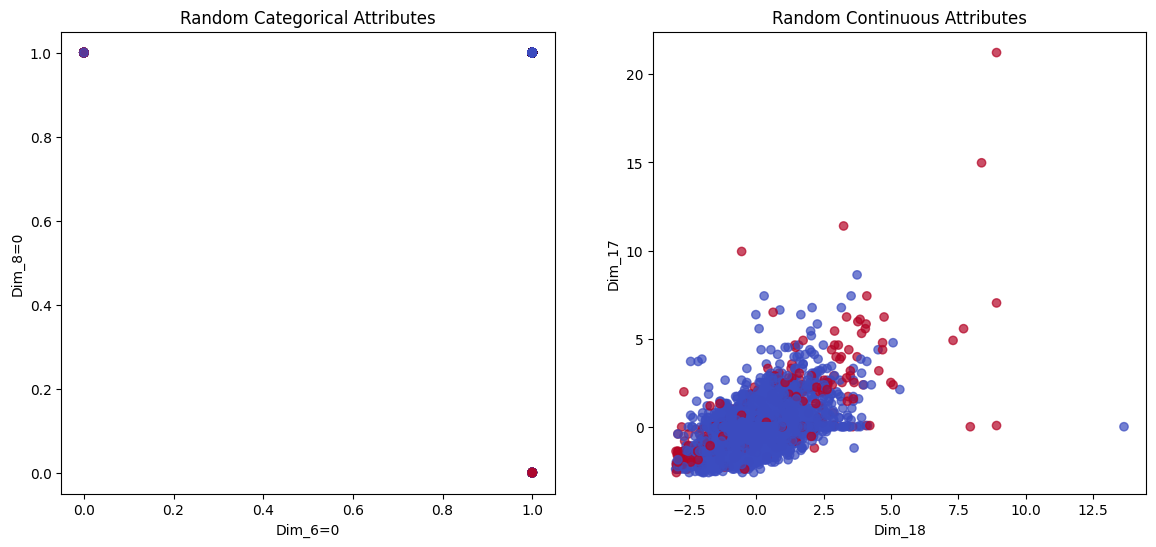

In [ ]:
# Plot random attributes with the detected anomalies
plot_random_attributes(df,'IF_anomaly' ,categorical_features, continuous_features, n_plots=5)

In [ ]:
# The number of anomalies detected by the Isolation Forest
anomaly_count = df['IF_anomaly'].value_counts().get('anomaly', 0)

print(f"The number of anomalies detected by the Isolation Forest {anomaly_count}")

The number of anomalies detected by the Isolation Forest 360


# Compare The Methods

In [ ]:
add_cluster_labels(df, dbscan_labels, column_name='Labels')
# Add DBSCAN Anomaly Labels to dataframe
df['DBSCAN_Anomaly'] = df['Labels'].apply(lambda x: 'anomaly' if x == -1 else 'normal')

In [ ]:
df['NN_anomaly'] = 'normal'  # Default to 'normal'
# Add NN Anomaly Labels to dataframe
df.loc[outliers, 'NN_anomaly'] = 'anomaly'  # Set 'anomaly' for the outliers

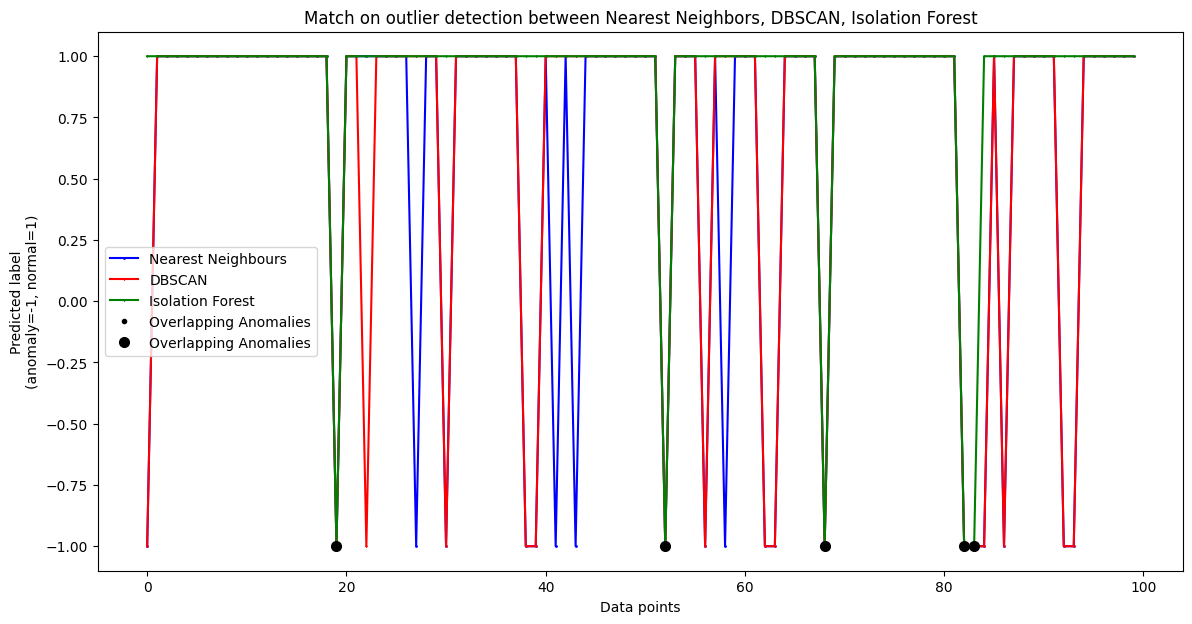

In [ ]:
# Ensure the correct function to convert labels is defined
def convert_labels(label):
    return -1 if label == 'anomaly' else 1

# Apply the conversion for plotting
nn_anomaly_plot = df['NN_anomaly'].apply(convert_labels)
dbscan_anomaly_plot = df['DBSCAN_Anomaly'].apply(convert_labels)
isolation_anomaly_plot = df['IF_anomaly'].apply(convert_labels)

# Identify overlapping anomalies for all of the methods
overlap_anomalies = (nn_anomaly_plot == -1) & (dbscan_anomaly_plot == -1) & (isolation_anomaly_plot == -1)

# Select only the first 100 data points for plotting
num_points = 100
subset_indices = df.index[:num_points]
anomaly_plot_subset = nn_anomaly_plot[:num_points]
dbscan_anomaly_plot_subset = dbscan_anomaly_plot[:num_points]
isolation_anomaly_plot_subset = isolation_anomaly_plot[:num_points]
overlap_anomalies_subset = overlap_anomalies[:num_points]

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(subset_indices, anomaly_plot_subset, 'bo-', markersize=1, label='Nearest Neighbours')
plt.plot(subset_indices, dbscan_anomaly_plot_subset, 'rx-', markersize=1, label='DBSCAN')
plt.plot(subset_indices, isolation_anomaly_plot_subset, 'gx-', markersize=1, label='Isolation Forest')
plt.plot(subset_indices[overlap_anomalies_subset], anomaly_plot_subset[overlap_anomalies_subset], 'ko', markersize=3, label='Overlapping Anomalies')
# Highlight overlapping anomalies
plt.plot(subset_indices[overlap_anomalies_subset], anomaly_plot_subset[overlap_anomalies_subset], 'ko', markersize=7, label='Overlapping Anomalies')
plt.xlabel('Data points')
plt.ylabel('Predicted label\n(anomaly=-1, normal=1)')
plt.title('Match on outlier detection between Nearest Neighbors, DBSCAN, Isolation Forest')
plt.legend()
plt.show()

In [ ]:
# The number of anomalies detected by both DBSCAN and Isolation Forest Algorirthms
print(f"The number of anomalies detected by both DBSCAN and Isolation Forest Algorirthms:{overlap_anomalies.sum()}")

The number of anomalies detected by both DBSCAN and Isolation Forest Algorirthms:357


In [ ]:
nn_isolation_overlap_anomalies = (nn_anomaly_plot == -1) & (isolation_anomaly_plot == -1)
print(f"{(nn_isolation_overlap_anomalies.sum() / (isolation_anomaly_plot == -1).sum())*100}% of anomalies detected by Isolation Forest overlaps with anomalies detected by Nearest Neighbors")

100.0% of anomalies detected by Isolation Forest overlaps with anomalies detected by Nearest Neighbors


In [ ]:
nn_dbscan_overlap_anomalies = (nn_anomaly_plot == -1) & (dbscan_anomaly_plot == -1)
overlap_percentage1 = (nn_dbscan_overlap_anomalies.sum() / (dbscan_anomaly_plot == -1).sum())*100
print(f"{overlap_percentage1:.2f}% of anomalies detected by DBSCAN overlaps with anomalies detected by Nearest Neighbors")

92.73% of anomalies detected by DBSCAN overlaps with anomalies detected by Nearest Neighbors


In [ ]:
dbscan_isolation_overlap_anomalies = (dbscan_anomaly_plot == -1) & (isolation_anomaly_plot == -1)
overlap_percentage2 = (dbscan_isolation_overlap_anomalies.sum() / (isolation_anomaly_plot == -1).sum())*100
print(f"{overlap_percentage2:.2f}% of anomalies detected by Isolation Forest overlaps with anomalies detected by DBSCAN")

99.17% of anomalies detected by Isolation Forest overlaps with anomalies detected by DBSCAN


Since the anomalies detected by Isolation Forest overlaps almost 100% with the other methods, it is chosen as best anomaly detection algorithm for the dataset.

In [ ]:
# The number of outliers both detected by NN and DBSCAN
nn_dbscan_overlap_anomalies.sum()

1390

In [ ]:
# Identify overlapping anomalies at least two of the methods
at_least_two_overlap_anomalies = (
    ((nn_anomaly_plot == -1) & (dbscan_anomaly_plot == -1)) |
    ((nn_anomaly_plot == -1) & (isolation_anomaly_plot == -1)) |
    ((dbscan_anomaly_plot == -1) & (isolation_anomaly_plot == -1))
)

print(nn_dbscan_overlap_anomalies.sum() / at_least_two_overlap_anomalies.sum() * 100)
at_least_two_overlap_anomalies.sum()

99.78463747307968


1393

Since the anomalies found by Nearest Negihbours and DBSCAN methods are 92% same and the anomalies at least found by two of them %99.78 same as overlaped anomailes of Nearest Negihbours and DBSCAN, it is proved that two methods verifies each other.  

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

# NN vs DBSCAN outliers
print("NN vs DBSCAN outliers:")
print(f"Homogeneity: {metrics.homogeneity_score(nn_anomaly_plot, dbscan_anomaly_plot):.3f}") # Measure of how much each cluster contains only data points that are members of a single class
print(f"Completeness: {metrics.completeness_score(nn_anomaly_plot, dbscan_anomaly_plot):.3f}") # Measure of how well all members of a given class are assigned to the same cluster
print(f"V-measure: {metrics.v_measure_score(nn_anomaly_plot, dbscan_anomaly_plot):.3f}") #  This is the harmonic mean of homogeneity and completeness
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(nn_anomaly_plot, dbscan_anomaly_plot):.3f}") # This index measures the similarity between the two clusterings by considering all pairs of samples
                                                                                                       # and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(nn_anomaly_plot, dbscan_anomaly_plot):.3f}") # This metric measures the agreement of the two assignments, ignoring permutations and with chance normalization

NN vs DBSCAN outliers:
Homogeneity: 0.655
Completeness: 0.680
V-measure: 0.668
Adjusted Rand Index: 0.806
Adjusted Mutual Information: 0.667


These results suggest that while there are some differences between the two algorithms in detecting outliers, they generally agree on the clustering structure. The high ARI score, in particular, indicates a strong alignment between the results of NN and DBSCAN.

In [ ]:
# IF vs NN outliers
print("IF vs NN outliers:")
print(f"Homogeneity: {metrics.homogeneity_score(isolation_anomaly_plot, nn_anomaly_plot):.3f}")
print(f"Completeness: {metrics.completeness_score(isolation_anomaly_plot, nn_anomaly_plot):.3f}")
print(f"V-measure: {metrics.v_measure_score(isolation_anomaly_plot, nn_anomaly_plot):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(isolation_anomaly_plot, nn_anomaly_plot):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(isolation_anomaly_plot, nn_anomaly_plot):.3f}")

IF vs NN outliers:
Homogeneity: 0.402
Completeness: 0.150
V-measure: 0.218
Adjusted Rand Index: 0.238
Adjusted Mutual Information: 0.218


In [ ]:
# DBSCAN vs IF outliers isolation_anomaly_plot
print("DBSCAN vs IF outliers:")
print(f"Homogeneity: {metrics.homogeneity_score(dbscan_anomaly_plot, isolation_anomaly_plot):.3f}")
print(f"Completeness: {metrics.completeness_score(dbscan_anomaly_plot, isolation_anomaly_plot):.3f}")
print(f"V-measure: {metrics.v_measure_score(dbscan_anomaly_plot, isolation_anomaly_plot):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(dbscan_anomaly_plot, isolation_anomaly_plot):.3f}")
print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(dbscan_anomaly_plot, isolation_anomaly_plot):.3f}")

DBSCAN vs IF outliers:
Homogeneity: 0.158
Completeness: 0.406
V-measure: 0.227
Adjusted Rand Index: 0.261
Adjusted Mutual Information: 0.227


These results are lower because Isolation Forest found much less anomalies compared to the other two methods.

PCA - TSNE comparison

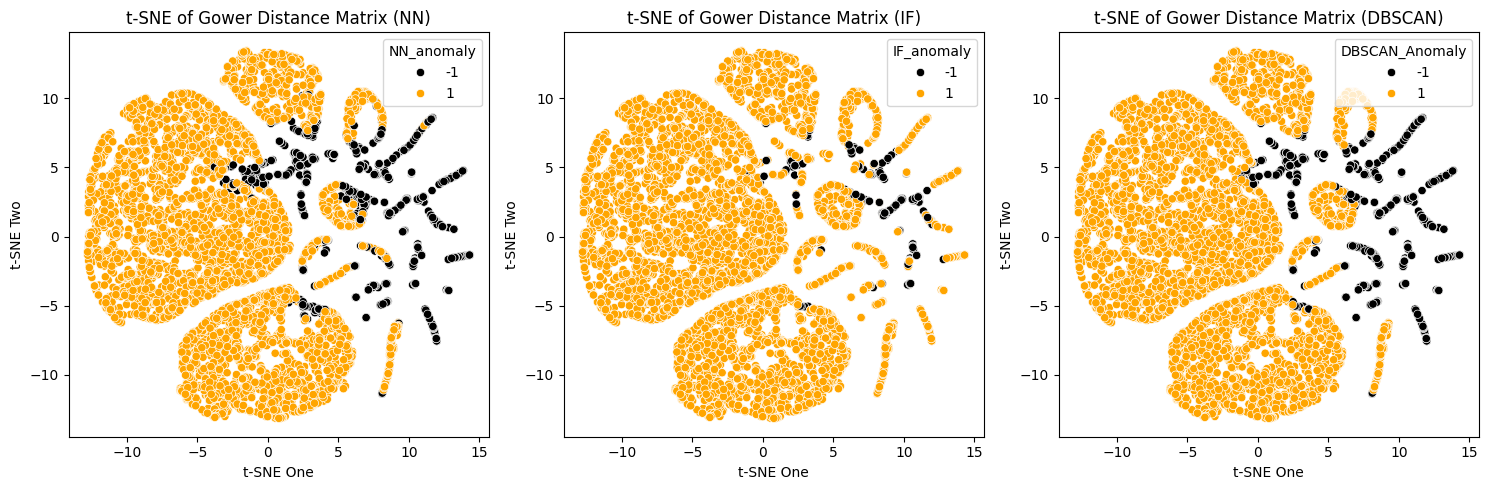

In [ ]:
#from sklearn.decomposition import PCA

np.random.seed(100)

"""
pca = PCA(n_components=2)

pca_results = pca.fit_transform(gower_dist_matrix)

# Setting up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for PCA
axes[0].set_title('PCA of Gower Distance Matrix (NN)')
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=nn_anomaly_plot, palette=['black','orange'], ax=axes[0])
axes[0].set_xlabel('PCA One')
axes[0].set_ylabel('PCA Two')

axes[1].set_title('PCA of Gower Distance Matrix (IF)')
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=isolation_anomaly_plot, palette=['black','orange'], ax=axes[1])
axes[1].set_xlabel('PCA One')
axes[1].set_ylabel('PCA Two')

axes[2].set_title('PCA of Gower Distance Matrix (DBSCAN)')
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=dbscan_anomaly_plot, palette=['black','orange'], ax=axes[2])
axes[2].set_xlabel('PCA One')
axes[2].set_ylabel('PCA Two')

plt.tight_layout()
plt.show()
"""

# Setting up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot for PCA
axes[0].set_title('t-SNE of Gower Distance Matrix (NN)')
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=nn_anomaly_plot, palette=['black','orange'], ax=axes[0])
axes[0].set_xlabel('t-SNE One')
axes[0].set_ylabel('t-SNE Two')

axes[1].set_title('t-SNE of Gower Distance Matrix (IF)')
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=isolation_anomaly_plot, palette=['black','orange'], ax=axes[1])
axes[1].set_xlabel('t-SNE One')
axes[1].set_ylabel('t-SNE Two')

axes[2].set_title('t-SNE of Gower Distance Matrix (DBSCAN)')
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=dbscan_anomaly_plot, palette=['black','orange'], ax=axes[2])
axes[2].set_xlabel('t-SNE One')
axes[2].set_ylabel('t-SNE Two')

plt.tight_layout()
plt.show()




In the visualizations tSNE;


*   The most of the anomalies detected by Isolation Forest also detected by the other two methods.
*   Nearest Neighbors and DBSCAN results are quite similar.



In addition: PCA might not be the best method for visualization, due to its linear nature and the presence of binary features. t-SNE has shown to be effective in this case.

In [ ]:
df

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,IF_anomaly_scores,IF_anomaly,Labels,DBSCAN_Anomaly,NN_anomaly
0,1.106869,1,0,1,1,1,1,1,0,1,...,-0.185460,-0.660168,0.293878,-0.829940,0.908303,0.034950,normal,-1,anomaly,anomaly
1,-1.482215,1,1,1,1,1,1,1,1,1,...,-0.200684,1.329573,0.933377,1.842567,-0.144473,0.150992,normal,0,normal,normal
2,-0.266928,1,1,1,1,1,1,1,1,1,...,-0.128880,0.533676,-0.206589,1.737765,-0.975611,0.162164,normal,0,normal,normal
3,0.631323,0,1,1,1,1,1,1,1,1,...,-0.172405,-0.394869,-0.901688,-0.410723,-0.781670,0.160205,normal,1,normal,normal
4,-1.535050,1,1,1,1,1,1,1,1,1,...,-0.200684,0.798975,0.822161,-0.410723,1.102244,0.160322,normal,0,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.367133,1,1,1,1,1,1,1,1,1,...,-0.102769,0.109203,-0.846071,0.060899,-0.920202,0.098615,normal,6,normal,normal
7196,-0.055578,1,1,1,1,1,1,1,1,1,...,4.401598,-1.854013,-2.903570,-0.463130,-2.984192,0.031527,normal,0,normal,anomaly
7197,-0.055578,1,1,1,1,1,1,1,1,1,...,-0.178494,0.016341,-0.540238,-1.615978,0.575847,0.094180,normal,6,normal,normal
7198,-0.900989,0,1,1,1,1,1,1,1,1,...,-0.089714,0.016341,-0.540238,-0.463130,-0.338396,0.161272,normal,1,normal,normal
